In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'HYP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'HYP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(148, 300)
(148, 1)


In [3]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[7])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'HYP', 'ATP Label', 'HYP Label', 'INDEX MEDU'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['ATP'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[6])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','HYP'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(20, 300)
(20, 1)
<class 'pandas.core.frame.DataFrame'>


In [4]:
interpolated_data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,0.640369,0.498260,0.486767,0.679340,0.647836,0.771028,0.580125,0.523624,0.549084,0.531644,...,0.132742,0.144950,0.167203,0.195446,0.147017,0.103436,0,0.750000,14.0,1
1,-0.201289,-0.009675,0.236328,0.110132,-0.172074,0.404189,0.214570,-0.067842,0.175427,0.096374,...,0.159958,0.204727,0.255312,0.231132,0.283782,0.418953,1,0.750000,8.0,1
2,-0.094138,0.032406,0.183322,0.126899,-0.064361,0.382030,0.165874,-0.175117,0.090313,0.019391,...,0.156959,0.246642,0.433583,0.350745,0.233091,0.161711,0,0.833333,10.0,1
3,-0.011933,0.209546,0.390546,0.284583,-0.032678,0.486978,0.246892,0.073225,0.347454,0.301431,...,0.199174,0.232535,0.420176,0.284627,0.275648,0.274123,0,0.916667,10.0,1
4,-0.214126,-0.075196,0.160270,0.019380,-0.189347,0.335372,0.152731,-0.167334,0.141346,0.036927,...,0.123159,0.228639,0.253390,0.268384,0.216538,0.252791,1,0.833333,16.0,1


In [5]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(218, 300)
(218, 300)
(218, 300)
(218, 300)
(218, 300)
(220, 300)
(220, 300)
(220, 300)


In [6]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,-0.167723,0.033785,0.149685,0.050587,-0.283762,0.625061,0.187606,-0.197612,0.235310,0.106251,...,0.062580,0.284816,0.407863,0.208103,0.475556,0.086871,0.0,0.750000,14.0,0.991781
1,-0.116216,-0.086548,0.254434,0.164892,-0.229623,0.311852,0.221111,0.103804,0.396944,0.164983,...,0.234383,0.516006,0.501607,0.436699,0.454235,0.317294,1.0,0.750000,9.0,1.016438
2,0.015747,-0.101754,0.306488,0.200862,-0.178784,0.465817,0.257937,-0.014865,0.412029,0.099495,...,0.422804,0.366829,0.730443,0.263909,0.410264,0.388674,1.0,0.916667,16.0,1.126027
3,-0.194265,-0.064244,0.200733,0.074212,-0.201491,0.401558,0.218512,-0.031789,0.302988,-0.029465,...,0.112450,0.110412,0.246215,0.145806,0.275628,0.223729,0.0,0.583333,13.0,1.150685
4,-0.247304,0.054458,0.328019,0.138133,0.001408,0.409507,0.126695,-0.044608,0.231406,0.127242,...,0.232279,0.566873,0.859028,0.604834,0.626633,0.225424,1.0,0.750000,12.0,1.073973


In [7]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(218, 300)
(218, 300)
(218, 300)
(218, 300)
(218, 300)
(220, 300)
(220, 300)
(220, 300)
----------
(238, 300)
(238, 300)
(238, 300)
(238, 300)
(238, 300)
(240, 300)
(240, 300)
(240, 300)
Label shapes
(218, 1)
(218, 1)
(218, 1)
(218, 1)
(218, 1)
(220, 1)
(220, 1)
(220, 1)
----------
(238, 1)
(238, 1)
(238, 1)
(238, 1)
(238, 1)
(240, 1)
(240, 1)
(240, 1)


In [8]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [9]:
testing_fold_Y_1.shape

(19, 1)

In [10]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.508814 using {'batch_size': 35, 'dropout': 0.15, 'epochs': 35, 'layer1_size': 100, 'layer2_size': 15}
D_in, H1, H2, D_out = 300, 100, 15, 1
EPOCHS = 35
BATCH_SIZE = 35
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.15

test_size = 19
test_size1 = 18

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [11]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(19, 300)
(19, 300)
(19, 300)
(19, 300)
(18, 300)
(18, 300)
(18, 300)
(18, 300)


In [12]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [13]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model1's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.to(device)
print(model1)
weights1 = torch.FloatTensor([5]) #Class weights
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model2's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.to(device)
print(model2)
weights2 = torch.FloatTensor([5]) #Class weights
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model3's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.to(device)
print(model3)
weights3 = torch.FloatTensor([5]) #Class weights
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model4's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.to(device)
print(model4)
weights4 = torch.FloatTensor([5]) #Class weights
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model5's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.to(device)
print(model5)
weights5 = torch.FloatTensor([5]) #Class weights
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model6's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.to(device)
print(model6)
weights6 = torch.FloatTensor([5]) #Class weights
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model7's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.to(device)
print(model7)
weights7 = torch.FloatTensor([5]) #Class weights
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=15, bias=True)
  (l

In [14]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.76532 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.49606 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.41814 | Acc: 45.714
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.41290 | Acc: 45.571


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.36179 | Acc: 45.714
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36746 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34223 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.34743 | Acc: 45.857


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.32375 | Acc: 46.714
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.31620 | Acc: 46.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.30249 | Acc: 46.286


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.24940 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.21469 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.17040 | Acc: 45.571


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.10913 | Acc: 47.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.06424 | Acc: 48.571
Validation Accuracy |  26.31578947368421  PPV |  [1.         0.17647059]  Recall |  [0.125 1.   ]
Training Epoch 017: | Loss: 0.98561 | Acc: 55.000
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.16666667]  Recall |  [0.0625 1.    ]
Training Epoch 018: | Loss: 0.91685 | Acc: 54.286
Validation Accuracy |  36.84210526315789  PPV |  [1.  0.2]  Recall |  [0.25 1.  ]
Training Epoch 019: | Loss: 0.82849 | Acc: 66.571
Validation Accuracy |  31.57894736842105  PPV |  [1.     0.1875]  Recall |  [0.1875 1.    ]
Training Epoch 020: | Loss: 0.75706 | Acc: 69.000
Validation Accuracy |  47.368421052631575  PPV |  [1.         0.23076923]  Recall |  [0.375 1.   ]
Training Epoch 021: | Loss: 0.68062 | Acc:

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.67250 | Acc: 46.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.42708 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.38551 | Acc: 45.857
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37725 | Acc: 46.571
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474] 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

 Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.34360 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34537 | Acc: 45.714
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.32075 | Acc: 46.429


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.31642 | Acc: 46.571
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.28464 | Acc: 46.571
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.26263 | Acc: 46.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.24488 | Acc: 46.571
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.18283 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.16746 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.09558 | Acc: 48.286
Validation Accuracy |  15.789473684210526  PPV |  [0.5        0.11764706]  Recall |  [0.0625     0.66666667]
Training Epoch 015: | Loss: 1.02925 | Acc: 49.429
Validation Accuracy |  15.789473684210526  PPV |  [0.5        0.11764706]  Recall |  [0.0625     0.66666667]
Training Epoch 016: | Loss: 0.92168 | Acc: 58.714
Validation Accuracy |  21.052631578947366  PPV |  [0.66666667 0.125     ]  Recall |  [0.125      0.66666667]
Training Epoch 017: | Loss: 0.83783 | Acc: 60.000
Validation Accuracy |  21.052631578947366  PPV |  [0.66666667 0.125     ]  Recall |  [0.125      0.66666667]
Training Epoch 018: | Loss: 0.76630 | Acc: 70.714
Validation Accuracy |  21.052631578947366  PPV |  [0.66666667 0.125     ]  Recall |  [0.125      0.66666667]
Training Epoch 019: | Loss: 0.65963 | Acc: 70.714
Validation Accuracy |  63.1578947368421  PPV |  [0.84615385 0.16666667]  Recall |  [0.6875     0.33333333]
Train

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.74212 | Acc: 47.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.54124 | Acc: 46.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.41776 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.39424 | Acc: 46.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.37618 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36329 | Acc: 45.857
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34945 | Acc: 46.714
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.33371 | Acc: 46.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.29436 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.28554 | Acc: 46.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.26469 | Acc: 46.857

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s


Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.24817 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.21733 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.17985 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 015: | Loss: 1.13460 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.09952 | Acc: 46.571
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.05942 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.01207 | Acc: 46.714


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 0.98173 | Acc: 46.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 0.92343 | Acc: 45.714


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 021: | Loss: 0.90305 | Acc: 46.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 022: | Loss: 0.85392 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 023: | Loss: 0.80551 | Acc: 46.000
Validation Accuracy |  21.052631578947366  PPV |  [1.         0.16666667]  Recall |  [0.0625 1.    ]
Training Epoch 024: | Loss: 0.73874 | Acc: 66.000
Validation Accuracy |  26.31578947368421  PPV |  [0.75       0.13333333]  Recall |  [0.1875     0.66666667]
Training Epoch 025: | Loss: 0.64819 | Acc: 79.429
Validation Accuracy |  31.57894736842105  PPV |  [0.8        0.14285714]  Recall |  [0.25       0.66666667]
Training Epoch 026: | Loss: 0.58386 | Acc: 82.714
Validation Accuracy |  31.57894736842105  PPV |  [0.8        0.14285714]  Recall |  [0.25       0.666666

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.92428 | Acc: 52.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.54650 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.42629 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.42056 | Acc: 46.286
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 005: | Loss: 1.41377 | Acc: 46.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.38111 | Acc: 47.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.37612 | Acc: 46.000
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 008: | Loss: 1.35630 | Acc: 46.571
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.31837 | Acc: 45.857
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.28805 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.26650 | Acc: 46.571


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.22358 | Acc: 46.429
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.19635 | Acc: 47.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.15288 | Acc: 47.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.13984 | Acc: 48.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.06392 | Acc: 50.143
Validation Accuracy |  15.789473684210526  PPV |  [0.         0.15789474]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.03472 | Acc: 52.714


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  31.57894736842105  PPV |  [1.     0.1875]  Recall |  [0.1875 1.    ]
Training Epoch 018: | Loss: 0.97367 | Acc: 58.143
Validation Accuracy |  31.57894736842105  PPV |  [1.     0.1875]  Recall |  [0.1875 1.    ]
Training Epoch 019: | Loss: 0.91026 | Acc: 58.714
Validation Accuracy |  47.368421052631575  PPV |  [1.         0.23076923]  Recall |  [0.375 1.   ]
Training Epoch 020: | Loss: 0.84164 | Acc: 66.000
Validation Accuracy |  52.63157894736842  PPV |  [1.   0.25]  Recall |  [0.4375 1.    ]
Training Epoch 021: | Loss: 0.80331 | Acc: 71.429
Validation Accuracy |  47.368421052631575  PPV |  [1.         0.23076923]  Recall |  [0.375 1.   ]
Training Epoch 022: | Loss: 0.73386 | Acc: 71.000
Validation Accuracy |  52.63157894736842  PPV |  [0.88888889 0.2       ]  Recall |  [0.5        0.66666667]
Training Epoch 023: | Loss: 0.68818 | Acc: 76.143
Validation Accuracy |  63.1578947368421  PPV |  [0.90909091 0.25      ]  Recall |  [0.625      0.66666667]
Training Epoch 

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.88317 | Acc: 48.429
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.57939 | Acc: 46.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39754 | Acc: 47.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.36848 | Acc: 46.429
Validation Accuracy |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38075 | Acc: 46.286
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36742 | Acc: 46.286
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.35456 | Acc: 46.429
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 008: | Loss: 1.32730 | Acc: 46.429
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.31546 | Acc: 45.571
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.30580 | Acc: 46.714
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.27059 | Acc: 46.571


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.25801 | Acc: 46.286
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.23408 | Acc: 46.143
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.20049 | Acc: 46.571


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.15290 | Acc: 46.571
Validation Accuracy |  16.666666666666664  PPV |  [1.         0.11764706]  Recall |  [0.0625 1.    ]
Training Epoch 016: | Loss: 1.13623 | Acc: 47.143
Validation Accuracy |  16.666666666666664  PPV |  [1.         0.11764706]  Recall |  [0.0625 1.    ]
Training Epoch 017: | Loss: 1.03955 | Acc: 48.286
Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 018: | Loss: 1.01514 | Acc: 47.286
Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 019: | Loss: 0.97581 | Acc: 59.143
Validation Accuracy |  33.33333333333333  PPV |  [1.         0.14285714]  Recall |  [0.25 1.  ]
Training Epoch 020: | Loss: 0.92437 | Acc: 55.429
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 021: | Loss: 0.8364

In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.75075 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.44367 | Acc: 46.571
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37875 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.38924 | Acc: 46.571


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.36859 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34129 | Acc: 46.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.33911 | Acc: 46.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 008: | Loss: 1.32035 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.30568 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.29384 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.27562 | Acc: 45.857


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.25999 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.21509 | Acc: 46.000
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.18356 | Acc: 46.143


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.14478 | Acc: 46.571
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.08493 | Acc: 47.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.03756 | Acc: 47.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 1.00974 | Acc: 52.143


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 019: | Loss: 0.90783 | Acc: 52.857
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 020: | Loss: 0.87514 | Acc: 63.571
Validation Accuracy |  33.33333333333333  PPV |  [1.  0.2]  Recall |  [0.2 1. ]
Training Epoch 021: | Loss: 0.82044 | Acc: 61.143
Validation Accuracy |  27.77777777777778  PPV |  [1.     0.1875]  Recall |  [0.13333333 1.        ]
Training Epoch 022: | Loss: 0.81173 | Acc: 75.571
Validation Accuracy |  33.33333333333333  PPV |  [1.  0.2]  Recall |  [0.2 1. ]
Training Epoch 023: | Loss: 0.71611 | Acc: 66.286
Validation Accuracy |  50.0  PPV |  [1.   0.25]  Recall |  [0.4 1. ]
Training Epoch 024: | Loss: 0.62860 | Acc: 84.571
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.21428571]  Recall |  [0.26666667 1.        ]
Training Epoch 025: | Loss: 0.59177 | Acc: 77.286
Validation Accuracy |  77.7

In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.80823 | Acc: 47.000
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.46050 | Acc: 46.571
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37676 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.40330 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 005: | Loss: 1.37253 | Acc: 46.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34964 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.34259 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.31943 | Acc: 46.143


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.30378 | Acc: 46.571
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.29348 | Acc: 46.000
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.27790 | Acc: 46.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 012: | Loss: 1.22503 | Acc: 46.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.19532 | Acc: 46.000
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.15596 | Acc: 46.714
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.10608 | Acc: 47.286
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.08478 | Acc: 47.714
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.02018 | Acc: 48.286
Validation Accuracy |  22.22222222222222  PPV |  [1.         0.17647059]  Recall |  [0.06666667 1.        ]
Training Epoch 018: | Loss: 0.95873 | Acc: 53.429


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  22.22222222222222  PPV |  [1.         0.17647059]  Recall |  [0.06666667 1.        ]
Training Epoch 019: | Loss: 0.92379 | Acc: 59.857
Validation Accuracy |  22.22222222222222  PPV |  [1.         0.17647059]  Recall |  [0.06666667 1.        ]
Training Epoch 020: | Loss: 0.84145 | Acc: 60.000
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.21428571]  Recall |  [0.26666667 1.        ]
Training Epoch 021: | Loss: 0.79023 | Acc: 66.857
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.21428571]  Recall |  [0.26666667 1.        ]
Training Epoch 022: | Loss: 0.74638 | Acc: 76.429
Validation Accuracy |  38.88888888888889  PPV |  [1.         0.21428571]  Recall |  [0.26666667 1.        ]
Training Epoch 023: | Loss: 0.68763 | Acc: 70.286
Validation Accuracy |  77.77777777777779  PPV |  [1.         0.42857143]  Recall |  [0.73333333 1.        ]
Training Epoch 024: | Loss: 0.61631 | Acc: 84.714
Validation Accuracy |  38.88888888888889  PPV |  [1.

In [22]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.76692 | Acc: 50.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.44104 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.40289 | Acc: 46.286
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.40355 | Acc: 46.429


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.38010 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.36181 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.36393 | Acc: 46.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.34074 | Acc: 46.143


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.33779 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.31364 | Acc: 46.714
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.29558 | Acc: 46.143


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.25851 | Acc: 46.000
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.23036 | Acc: 46.429
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.18300 | Acc: 46.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 015: | Loss: 1.12629 | Acc: 47.143
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 1.06603 | Acc: 47.714
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 017: | Loss: 1.01998 | Acc: 52.857
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]
Training Epoch 018: | Loss: 0.95686 | Acc: 52.000
Validation Accuracy |  22.22222222222222  PPV |  [1.         0.17647059]  Recall |  [0.06666667 1.        ]
Training Epoch 019: | Loss: 0.85238 | Acc: 61.143


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  38.88888888888889  PPV |  [1.         0.21428571]  Recall |  [0.26666667 1.        ]
Training Epoch 020: | Loss: 0.78231 | Acc: 70.714
Validation Accuracy |  61.111111111111114  PPV |  [1.  0.3]  Recall |  [0.53333333 1.        ]
Training Epoch 021: | Loss: 0.70068 | Acc: 72.571
Validation Accuracy |  61.111111111111114  PPV |  [1.  0.3]  Recall |  [0.53333333 1.        ]
Training Epoch 022: | Loss: 0.63649 | Acc: 75.429
Validation Accuracy |  72.22222222222221  PPV |  [0.91666667 0.33333333]  Recall |  [0.73333333 0.66666667]
Training Epoch 023: | Loss: 0.56880 | Acc: 80.286
Validation Accuracy |  77.77777777777779  PPV |  [0.92307692 0.4       ]  Recall |  [0.8        0.66666667]
Training Epoch 024: | Loss: 0.50926 | Acc: 87.857
Validation Accuracy |  72.22222222222221  PPV |  [0.91666667 0.33333333]  Recall |  [0.73333333 0.66666667]
Training Epoch 025: | Loss: 0.45565 | Acc: 85.429
Validation Accuracy |  83.33333333333334  PPV |  [0.875 0.5  ]  Recall |  [0.9

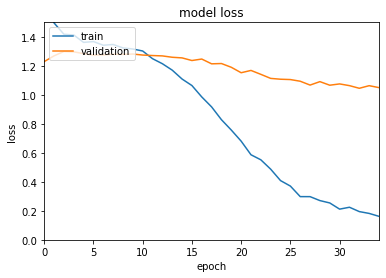

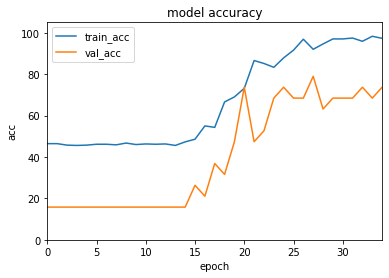

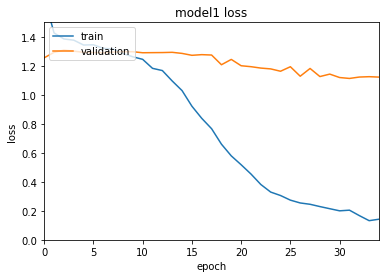

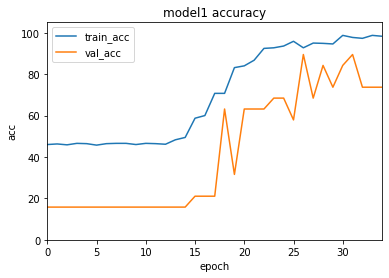

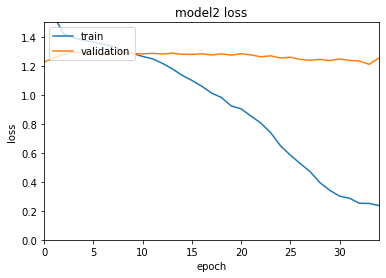

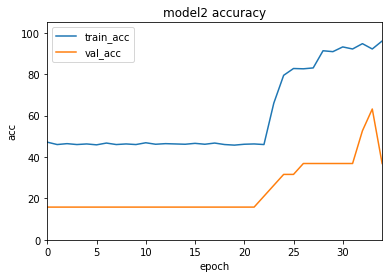

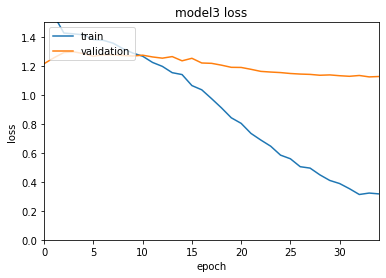

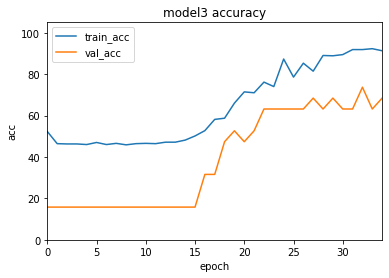

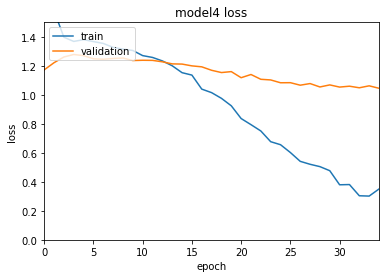

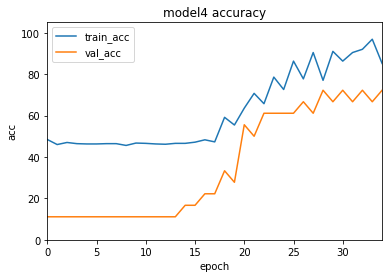

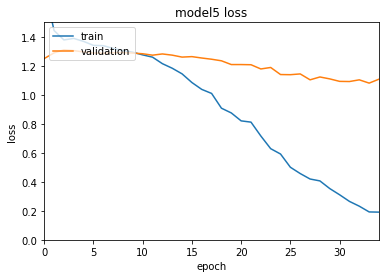

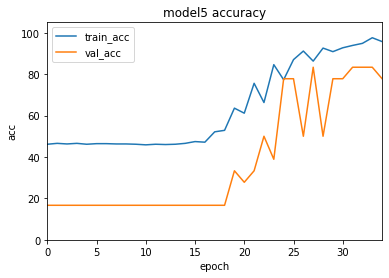

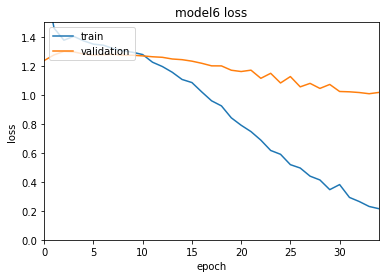

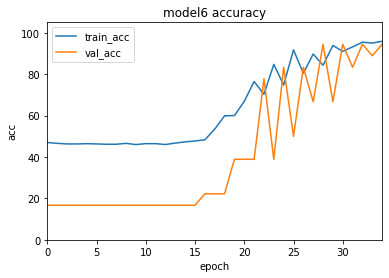

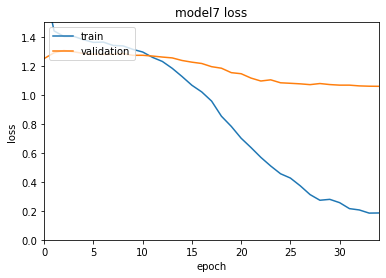

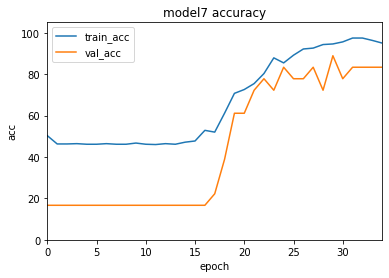

In [23]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  73.68421052631578  PPV |  [0.92307692 0.33333333]  Recall |  [0.75       0.66666667]


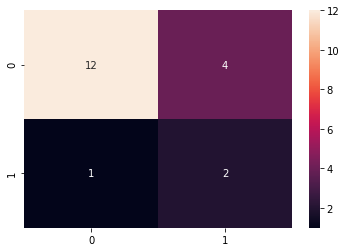

In [24]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  73.68421052631578  PPV |  [0.86666667 0.25      ]  Recall |  [0.8125     0.33333333]


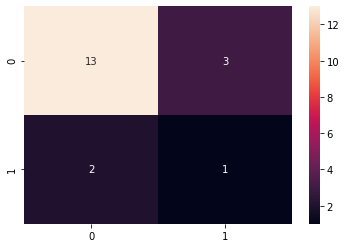

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  36.84210526315789  PPV |  [0.75       0.09090909]  Recall |  [0.375      0.33333333]


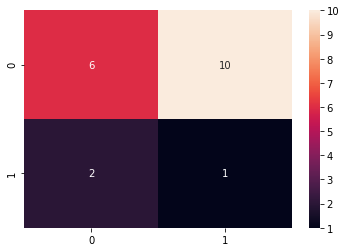

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  68.42105263157895  PPV |  [0.91666667 0.28571429]  Recall |  [0.6875     0.66666667]


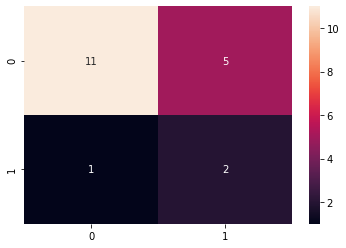

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]


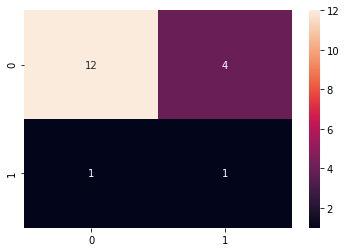

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  77.77777777777779  PPV |  [0.82352941 0.        ]  Recall |  [0.93333333 0.        ]


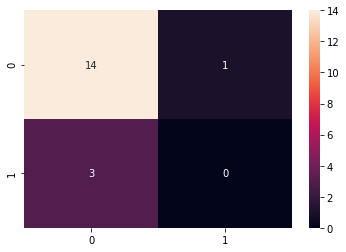

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  94.44444444444444  PPV |  [0.9375 1.    ]  Recall |  [1.         0.66666667]


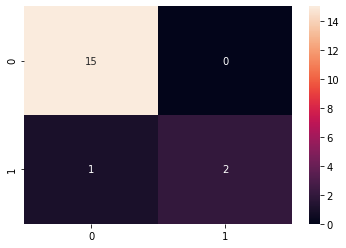

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  83.33333333333334  PPV |  [0.875 0.5  ]  Recall |  [0.93333333 0.33333333]


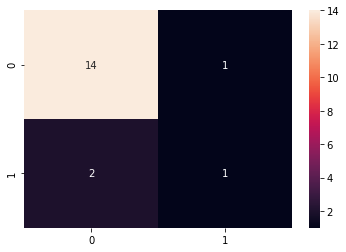

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [32]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0]

[[97 28]
 [13 10]]
Positive Predictive Value tp/(tp+fp):  0.2631578947368421
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.722972972972973
Recall Value tp/(tp+fn):  0.43478260869565216


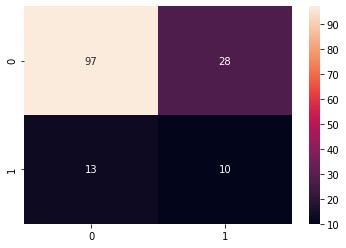

In [33]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 